In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import RDLogger
from rdkit.ML.Descriptors import MoleculeDescriptors

from sklearn.neighbors import DistanceMetric
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from scipy.special import expit as sigmoid

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

import lightgbm as lgb

from tqdm import trange
import warnings
warnings.filterwarnings("ignore")
RDLogger.DisableLog('rdApp.*')

RDKit WARNING: [16:55:49] Enabling RDKit 2019.09.3 jupyter extensions
[16:55:49] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
RANDOM_STATE = 2022
NA_CODE = -999
N_TASKS = 11
REFIT_LSTM = False
LSTM_PATH = 'lstm.pth'
TRAIN_FILE = 'data/data_train.csv'
SUBMISSION_FILE = 'data/submission.csv'

## Exploration

In [3]:
data = pd.read_csv('data/data_train.csv', index_col=0).reset_index(drop=True)
data = data.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
data

,smiles,task1,task2,task3,task4,task5,task6,task7,task8,task9,task10,task11
0,CNCCc1ccc(O)c(O)c1.Cl,0,0,0,0,0,0,0,-1,0,0,0
1,CS(=O)(=O)O,0,0,0,0,0,0,-1,0,-1,0,0
2,OC1CCN(Cc2ccsc2)CC1,0,0,0,1,0,0,0,0,0,0,0
3,N#Cc1ccncc1,0,0,0,0,0,0,-1,0,-1,0,0
4,Nc1c(Cl)cc([N+](=O)[O-])cc1Cl,0,0,0,0,0,0,-1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11995,C=C(C)CNCC(=O)N(C)c1ccc(Cl)cc1C(=O)c1ccccc1,0,0,0,0,0,0,0,0,0,1,0
11996,CN=C(O)NCc1c(F)cccc1Cl,0,0,0,-1,0,0,0,0,0,0,0
11997,O=C(O)CON=C(O)c1ccccc1,0,0,0,0,0,0,-1,0,-1,0,0
11998,C/C(=C\CNc1nc[nH]c2ncnc1-2)CO,0,0,0,0,0,0,0,-1,0,0,0


Largest smiles length: 1
Shortest smiles length: 1157


<AxesSubplot:>

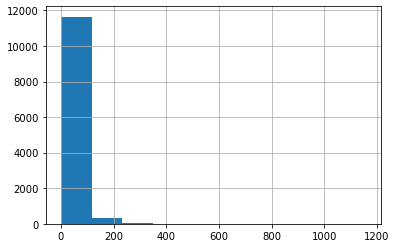

In [4]:
# smiles lengths
smiles_lengths = data['smiles'].map(len)
print(f'Largest smiles length: {smiles_lengths.min()}')
print(f'Shortest smiles length: {smiles_lengths.max()}')

smiles_lengths.hist()

In [5]:
# alphabet
def get_alphabet(data):
    alphabet = set(''.join(data['smiles']))
    return sorted(alphabet)

alphabet = get_alphabet(data)
print(f'Alphabet: {alphabet}')
print(f'Alphabet length: {len(alphabet)}')

Alphabet: ['#', '(', ')', '+', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', '@', 'A', 'B', 'C', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'S', 'T', 'Z', '[', '\\', ']', 'a', 'c', 'd', 'e', 'f', 'g', 'i', 'l', 'n', 'o', 'r', 's', 't', 'u']
Alphabet length: 52


In [6]:
# assay lengths
task_columns = [col for col in data.columns if col.startswith('task')]
assay_lengths = data[task_columns].abs().sum(axis=1)
assay_lengths.value_counts().sort_index()

0     469
1    6947
2    3288
3     670
4     241
5     158
6     101
7      51
8      48
9      27
dtype: int64

In [7]:
# task lengths / missingness
task_lengths = data[task_columns].abs().sum(axis=0)
task_lengths

task1     1023
task2      632
task3      962
task4      610
task5      632
task6     1010
task7     4311
task8     3804
task9     3626
task10    1314
task11     953
dtype: int64

In [8]:
# imbalancedness
actives = (data[task_columns]==1).sum(axis=0)
actives / task_lengths

task1     0.451613
task2     0.500000
task3     0.662162
task4     0.075410
task5     0.193038
task6     0.059406
task7     0.070981
task8     0.012618
task9     0.172090
task10    0.764079
task11    0.076600
dtype: float64

In [9]:
data = data.replace(0, NA_CODE) # encode missing as -999
data = data.replace(-1, 0) # encode inactive as 0
Y = data[task_columns].values
X = data['smiles'].values

## Morgan Fingerprints

In [10]:
def get_fingerprints(smiles, nBits, radius):
    fingerprints = np.empty((len(smiles), nBits))
    for (i, s) in enumerate(smiles):
        mol = Chem.MolFromSmiles(s)
        vec = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
        fingerprints[i, :] = np.array(vec)
    return fingerprints

## Jaccard-PCA Embedding

In [11]:
n_components = 2
nBits = 256
radius = 3
metric = 'jaccard'

In [12]:
def get_distance_matrix(smiles, nBits, radius, metric):
    fingerprints = get_fingerprints(smiles, nBits=nBits, radius=radius)
    distance_metric = DistanceMetric.get_metric(metric)
    distance_matrix = distance_metric.pairwise(fingerprints)
    return distance_matrix

def fit_pca(distance_matrix, n_components):
    pca = PCA(n_components)
    pca.fit(distance_matrix)
    print(f'Explained Variance Ratio ... {pca.explained_variance_ratio_}')
    return pca

Explained Variance Ratio ... [0.48639041 0.05752774]


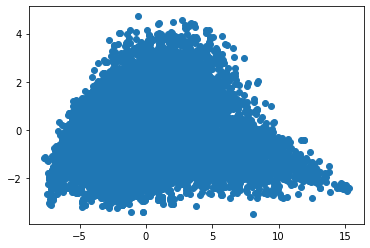

In [13]:
distance_matrix = get_distance_matrix(X, nBits, radius, metric)
pca = fit_pca(distance_matrix, n_components)
pca_embedding = pca.transform(distance_matrix)

plt.scatter(pca_embedding[:, 0], pca_embedding[:, 1])

In [14]:
# inspection 1
#idx = (pca_embedding[:, 0] > 24) & (pca_embedding[:, 1] < -3)

# inspection 2
#idx = (pca_embedding[:, 0] <-10) & (pca_embedding[:, 1] < -2)

# inspection 3
idx = (pca_embedding[:, 1] > 4)

data.iloc[idx]

,smiles,task1,task2,task3,task4,task5,task6,task7,task8,task9,task10,task11
70,CCCOC(=O)c1ccccc1,-999,-999,-999,-999,-999,-999,0,0,0,-999,-999
795,O=C(O)Cc1ccccc1,-999,-999,-999,-999,-999,-999,0,-999,0,-999,-999
911,NNc1ccccc1,-999,-999,-999,-999,-999,-999,0,-999,-999,-999,-999
1229,CNc1ccccc1,-999,-999,-999,-999,-999,-999,0,-999,0,-999,-999
1767,CC(=O)c1ccccc1,-999,-999,-999,-999,-999,-999,0,-999,0,-999,-999
1971,O=C(Cl)c1ccccc1,-999,-999,-999,-999,-999,-999,0,-999,0,-999,-999
2283,O=C([O-])c1ccccc1,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,0
2848,OCc1ccccc1,-999,-999,1,-999,-999,-999,0,-999,0,1,-999
2907,CCOC(=O)c1ccccc1,-999,-999,-999,-999,-999,-999,0,-999,0,-999,-999
5923,N=C(O)c1ccccc1Cl,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


## Semi-Supervised LSTM Alphabet Embedding

In [15]:
class Encoder:
    def __init__(self, alphabet):
        self.alphabet = alphabet
    
    def __call__(self, x):
        x = [c for c in x if c in self.alphabet]
        indices = [self.alphabet.index(c) for c in x]
        return np.array(indices)


class LSTMDataset(Dataset):
    def __init__(self, X, Y, encoder):
        super().__init__()
        self.X = X
        self.Y = Y
        self.encoder = encoder

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.encoder(self.X[idx])
        y = self.Y[idx, ...]
        t = len(x)
        return x, y, t


class LSTMCollate:
    def __call__(self, batch):
        lengths = [t for (x, y, t) in batch]
        max_length = max(lengths)
        x = [np.pad(x, (0, max_length-t)) for (x, y, t) in batch]
        y = [y for (x, y, t) in batch]
        t = [t for (x, y, t) in batch]
        return (
            torch.tensor(x, dtype=torch.long),
            torch.tensor(y, dtype=torch.float),
            torch.tensor(t, dtype=torch.long)
        )

In [16]:
# from lstm 
class SmilesLSTM(nn.Module):
    def __init__(self, alphabet_size, embedding_dim, hidden_dim, out_features):
        super().__init__()
        self.hidden_dim=hidden_dim
        self.embedding = nn.Embedding(alphabet_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, out_features)        

    def forward(self, x, t):
        embeddings = self.embedding(x)
        outputs, (h_l, c_l) = self.lstm(embeddings)
        outputs = torch.gather(outputs, dim=1, index=(t-1).reshape(-1, 1).unsqueeze(-1).repeat_interleave(self.hidden_dim, dim=2))
        outputs = self.linear(outputs)
        return outputs.squeeze(dim=1)

In [17]:
# from dlnn2
@torch.enable_grad()
def update_lstm(model, dataloader, metric, optimizer):
    errors = []
    model.train()
    for x, y, t in dataloader:
        preds = model(x, t)
        loss = metric(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        errors.append(loss.item())
    return errors

@torch.no_grad()
def evaluate_lstm(model, dataloader, metric):
    errors = []
    model.eval()
    with torch.no_grad():
        for x, y, t in dataloader:
            preds = model(x, t)
            weighted_masked_losses = metric(preds, y)
            loss = weighted_masked_losses.mean()
            errors.append(loss.item())
    return errors

In [18]:
# output hyperparameters
nBits = 512
radius = 3
metric = 'jaccard'
n_components = 10

# data splitting
test_size = 0.2

# preprocessing hyperparameters
alphabet = get_alphabet(data)
alphabet_size = len(alphabet)
encoder = Encoder(alphabet)

# lstm hyperparameters
embedding_dim = 8
hidden_dim = 128

# optimization hyperparameters
epochs = 20
batch_size = 8
learning_rate = 0.01
weight_decay = 0
step_size = 5
gamma = 0.1

In [19]:
if REFIT_LSTM:
    # input & output
    input = X.copy()
    distance_matrix = get_distance_matrix(input, nBits, radius, metric)
    pca = fit_pca(distance_matrix, n_components)
    output = pca.transform(distance_matrix)

In [20]:
if REFIT_LSTM:
    # data splitting
    X_train, X_val, Y_train, Y_val = train_test_split(input, output, test_size=test_size, random_state=RANDOM_STATE)

    # dataset & dataloader
    train_dataset = LSTMDataset(X_train, Y_train, encoder)
    val_dataset = LSTMDataset(X_val, Y_val, encoder)
    train_dataloader = DataLoader(train_dataset, batch_size, collate_fn=LSTMCollate(), shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size, collate_fn=LSTMCollate(), shuffle=False)

    # model etc.
    model = SmilesLSTM(alphabet_size, embedding_dim, hidden_dim, out_features=n_components)
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size, gamma)
    metric = nn.MSELoss()

    # training loop
    train_errors = [np.mean(evaluate_lstm(model, train_dataloader, metric))]
    val_errors = [np.mean(evaluate_lstm(model, val_dataloader, metric))]
    for _ in trange(epochs):
        train_errors.append(np.mean(update_lstm(model, train_dataloader, metric, optimizer)))
        val_errors.append(np.mean(evaluate_lstm(model, val_dataloader, metric)))
        scheduler.step()

    # learning curves
    plt.plot(range(epochs+1), train_errors, label='train errors')
    plt.plot(range(epochs+1), val_errors, label='validation errors')
    plt.legend()
    plt.show()

    # final epoch errors
    print(f'Final Train Error: {train_errors[-1]}')
    print(f'Final Validation Error: {val_errors[-1]}')

In [21]:
if REFIT_LSTM:
    # final fit
    dataset = LSTMDataset(input, output, encoder)
    dataloader = DataLoader(dataset, batch_size, collate_fn=LSTMCollate(), shuffle=True)
    model = SmilesLSTM(alphabet_size, embedding_dim, hidden_dim, out_features=n_components)
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size, gamma)
    metric = nn.MSELoss()

    # training loop
    errors = [np.mean(evaluate_lstm(model, dataloader, metric))]
    for _ in trange(epochs):
        errors.append(np.mean(update_lstm(model, dataloader, metric, optimizer)))
        scheduler.step()

    # learning curve
    plt.plot(range(epochs+1), errors, label='train errors')
    plt.legend()
    plt.show()

In [22]:
if REFIT_LSTM:
    torch.save(model.state_dict(), LSTM_PATH)
else:
    model = SmilesLSTM(alphabet_size, embedding_dim, hidden_dim, out_features=n_components)
    model.load_state_dict(torch.load(LSTM_PATH))

model.eval()
lstm_embedding = model.embedding.weight.detach().numpy()

## Clustering

In [23]:
n_clusters = 100

In [24]:
def get_clusters(embedding, n_clusters, random_state):
    scaler = StandardScaler()
    scaled_embedding = scaler.fit_transform(embedding)
    kmeans = KMeans(n_clusters, random_state=random_state)
    kmeans.fit(scaled_embedding)
    return kmeans.labels_


kmeans_labels = get_clusters(pca_embedding, n_clusters, RANDOM_STATE)
data['cluster'] = kmeans_labels

[29, 30, 31, 33, 34, 36, 40, 48, 51, 51, 53, 53, 57, 57, 57, 59, 59, 59, 61, 61, 62, 65, 67, 68, 69, 70, 71, 72, 76, 77, 79, 83, 85, 86, 88, 92, 93, 95, 95, 97, 98, 99, 99, 99, 101, 103, 104, 105, 111, 111, 112, 113, 113, 114, 114, 117, 119, 120, 125, 125, 126, 128, 128, 130, 135, 137, 138, 148, 148, 161, 163, 163, 167, 167, 169, 173, 175, 178, 183, 184, 185, 186, 188, 192, 194, 195, 195, 199, 204, 205, 205, 206, 210, 211, 212, 223, 224, 225, 231, 258]


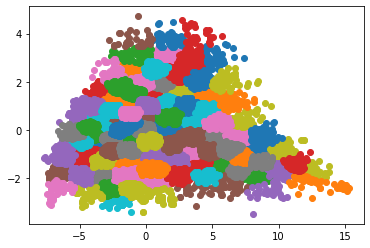

In [25]:
# cluster sizes
print(sorted(np.unique(kmeans_labels, return_counts=True)[1]))

# plot clusters
for c in np.unique(kmeans_labels):
    plt.scatter(pca_embedding[kmeans_labels==c, 0], pca_embedding[kmeans_labels==c, 1], label=str(c))

## Data Splitting

In [26]:
k = 5

In [27]:
group_kfold = GroupKFold(n_splits=k)
data['fold'] = np.nan
for i, (_, test_idx) in enumerate(group_kfold.split(X, Y, data['cluster'])):
    data['fold'].iloc[test_idx] = int(i)

In [28]:
# check for equal imbalancedness across folds
for t in range(len(task_columns)):
    for f in range(k):
        subset = data[data['fold']==f][task_columns[t]]
        task_length = subset[subset!=NA_CODE].count()
        actives = subset[subset==1].count()
        print(f'Task={t} ... Cluster={f} ... Share of Actives={round(actives / task_length, 2)}')

Task=0 ... Cluster=0 ... Share of Actives=0.29
Task=0 ... Cluster=1 ... Share of Actives=0.36
Task=0 ... Cluster=2 ... Share of Actives=0.47
Task=0 ... Cluster=3 ... Share of Actives=0.51
Task=0 ... Cluster=4 ... Share of Actives=0.57
Task=1 ... Cluster=0 ... Share of Actives=0.5
Task=1 ... Cluster=1 ... Share of Actives=0.47
Task=1 ... Cluster=2 ... Share of Actives=0.48
Task=1 ... Cluster=3 ... Share of Actives=0.57
Task=1 ... Cluster=4 ... Share of Actives=0.49
Task=2 ... Cluster=0 ... Share of Actives=0.64
Task=2 ... Cluster=1 ... Share of Actives=0.67
Task=2 ... Cluster=2 ... Share of Actives=0.67
Task=2 ... Cluster=3 ... Share of Actives=0.73
Task=2 ... Cluster=4 ... Share of Actives=0.59
Task=3 ... Cluster=0 ... Share of Actives=0.08
Task=3 ... Cluster=1 ... Share of Actives=0.07
Task=3 ... Cluster=2 ... Share of Actives=0.1
Task=3 ... Cluster=3 ... Share of Actives=0.02
Task=3 ... Cluster=4 ... Share of Actives=0.1
Task=4 ... Cluster=0 ... Share of Actives=0.15
Task=4 ... Clust

## Further Feature Engineering

In [29]:
def get_manual_features(X_train, X_val):
    train_lengths = np.array([len(s) for s in X_train]).reshape(-1, 1)
    val_lengths = np.array([len(s) for s in X_val]).reshape(-1, 1)
    return train_lengths, val_lengths

In [30]:
def get_dtm(X_train, X_val, ngram_range, max_features):
    count_vectorizer = CountVectorizer(lowercase=False, analyzer='char', ngram_range=ngram_range, max_features=max_features)
    train_dtm = count_vectorizer.fit_transform(X_train)
    val_dtm = count_vectorizer.transform(X_val)
    return train_dtm.toarray(), val_dtm.toarray()

In [31]:
def get_tfidf(X_train, X_val, ngram_range, max_features):
    tfidf_vectorizer = TfidfVectorizer(lowercase=False, analyzer='char', ngram_range=ngram_range, max_features=max_features)
    train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    val_tfidf = tfidf_vectorizer.transform(X_val)
    return train_tfidf.toarray(), val_tfidf.toarray()

In [32]:
def get_pca_embedding(X_train, X_val, nBits, radius, metric, n_components):
    X_train_val = np.concatenate((X_train, X_val))
    distance_matrix = get_distance_matrix(X_train_val, nBits, radius, metric)
    train_distance_matrix = distance_matrix[:len(X_train), :len(X_train)]
    val_distance_matrix = distance_matrix[len(X_train):, :len(X_train)]
    pca = fit_pca(train_distance_matrix, n_components)
    train_pca_embedding = pca.transform(train_distance_matrix)
    val_pca_embedding = pca.transform(val_distance_matrix)
    return train_pca_embedding, val_pca_embedding

In [33]:
class LSTMEmbedding:
    def __init__(self, embedding, alphabet, reduction='mean'):
        self.embedding = embedding 
        self.encoder = Encoder(alphabet)
        self.reduction = 'mean'

    def encode(self, x):
        indices = self.encoder(x)
        encoding = self.embedding[indices, :]
        if self.reduction=='mean':
            encoding = np.mean(encoding, axis=0)
        if self.reduction=='max':
            encoding = np.max(encoding, axis=0)
        return encoding

def get_lstm_embedding(X_train, X_val, lstm_embedding):
    train_embeddings = [lstm_embedding.encode(x) for x in X_train]
    val_embeddings = [lstm_embedding.encode(x) for x in X_val]
    return np.vstack(train_embeddings), np.vstack(val_embeddings)

In [34]:
def get_rdkit_descriptors(X_train, X_val):
    # select descriptors
    descriptor_list = Chem.Descriptors._descList
    names = [desc[0] for desc in descriptor_list]
    descriptor_calculator = MoleculeDescriptors.MolecularDescriptorCalculator(names)
    ipc_index = names.index('Ipc')
    # train
    train_rdkit = []
    for smiles in X_train:
        mol = Chem.MolFromSmiles(smiles)
        train_rdkit.append(descriptor_calculator.CalcDescriptors(mol))
    train_rdkit = np.nan_to_num(np.vstack(train_rdkit))
    train_rdkit[:, ipc_index] = np.log(train_rdkit[:, ipc_index] + 1)
    # val
    val_rdkit = []
    for smiles in X_val:
        mol = Chem.MolFromSmiles(smiles)
        val_rdkit.append(descriptor_calculator.CalcDescriptors(mol))
    val_rdkit = np.nan_to_num(np.vstack(val_rdkit))
    val_rdkit[:, ipc_index] = np.log(val_rdkit[:, ipc_index] + 1)
    return train_rdkit, val_rdkit

## Modeling

### Preparation

In [35]:
def get_fold_data(X, Y, val_fold):
    train_idx = data['fold']!=val_fold
    val_idx = data['fold']==val_fold
    return X[train_idx], X[val_idx], Y[train_idx], Y[val_idx]

In [36]:
def preprocess(X_train, X_val, nBits, radius, manual_features, dtm, tfidf, pca_embedding, lstm_embedding, rdkit_descriptors, scaler):
    X_train_features = get_fingerprints(X_train, nBits, radius)
    X_val_features = get_fingerprints(X_val, nBits, radius)
    if manual_features:
        train_features, val_features = get_manual_features(X_train, X_val)
        X_train_features = np.concatenate((X_train_features, train_features), axis=1)
        X_val_features = np.concatenate((X_val_features, val_features), axis=1)
    if dtm is not None:
        train_dtm, val_dtm = get_dtm(X_train, X_val, **dtm)
        X_train_features = np.concatenate((X_train_features, train_dtm), axis=1)
        X_val_features = np.concatenate((X_val_features, val_dtm), axis=1)
    if tfidf is not None:
        train_tfidf, val_tfidf = get_tfidf(X_train, X_val, **tfidf)
        X_train_features = np.concatenate((X_train_features, train_tfidf), axis=1)
        X_val_features = np.concatenate((X_val_features, val_tfidf), axis=1)
    if pca_embedding is not None:
        train_pca, val_pca = get_pca_embedding(X_train, X_val, **pca_embedding)
        X_train_features = np.concatenate((X_train_features, train_pca), axis=1)
        X_val_features = np.concatenate((X_val_features, val_pca), axis=1)  
    if lstm_embedding is not None:
        train_lstm, val_lstm = get_lstm_embedding(X_train, X_val, lstm_embedding)
        X_train_features = np.concatenate((X_train_features, train_lstm), axis=1)
        X_val_features = np.concatenate((X_val_features, val_lstm), axis=1)  
    if rdkit_descriptors:
        train_rdkit, val_rdkit = get_rdkit_descriptors(X_train, X_val)
        X_train_features = np.concatenate((X_train_features, train_rdkit), axis=1)
        X_val_features = np.concatenate((X_val_features, val_rdkit), axis=1)
    if scaler is not None:
        X_train_features = scaler.fit_transform(X_train_features)
        X_val_features = scaler.transform(X_val_features)
    return X_train_features, X_val_features

In [37]:
def mask_data(X, Y, task):
    task_idx = Y[:, task]!=NA_CODE
    return X[task_idx], Y[task_idx, task]

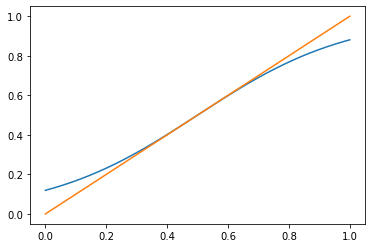

In [38]:
def get_sample_weights(Y, coef):
    n = len(Y)
    n1 = np.mean(Y) * n
    n0 = n - n1
    w0 = sigmoid(coef*(n0/n) - coef/2)
    w1 = sigmoid(coef*(n1/n) - coef/2)
    sample_weights = np.where(Y==0, w0*n/n0, w1*n/n1)
    return sample_weights

# illustration
coef = 4
x = np.linspace(0, 1, 1000)
y = sigmoid(coef*x - coef/2)
plt.plot(x, y)
plt.plot(x, x)

In [39]:
def get_metrics(y, proba):
    auc = roc_auc_score(y, proba)
    confusion = confusion_matrix(y, proba>0.5)
    return auc, confusion

In [40]:
def cross_validate_model(model, preprocessing_hyperparameters, coef):
    val_probas = np.empty((len(data), Y.shape[1]))
    train_auc_scores = [[] for task in range(Y.shape[1])]
    val_auc_scores = [[] for task in range(Y.shape[1])]
    train_confusion_matrices = [[] for task in range(Y.shape[1])]
    val_confusion_matrices = [[] for task in range(Y.shape[1])]

    for val_fold in range(k):
        X_train, X_val, Y_train, Y_val = get_fold_data(X, Y, val_fold)
        X_train_features, X_val_features = preprocess(X_train, X_val, **preprocessing_hyperparameters)
        for task in range(Y.shape[1]):
            # data preparation
            X_train_masked, Y_train_masked = mask_data(X_train_features, Y_train, task)
            X_val_masked, Y_val_masked = mask_data(X_val_features, Y_val, task)
            sample_weights = get_sample_weights(Y_train_masked, coef)
            # modeling
            model.fit(X_train_masked, Y_train_masked, sample_weights)
            # evaluation
            train_proba = model.predict_proba(X_train_masked)[:, 1]
            val_proba = model.predict_proba(X_val_masked)[:, 1]
            train_auc, train_confusion = get_metrics(Y_train_masked, train_proba)
            val_auc, val_confusion = get_metrics(Y_val_masked, val_proba)
            # store metrics
            train_auc_scores[task].append(train_auc)
            val_auc_scores[task].append(val_auc)
            train_confusion_matrices[task].append(train_confusion)
            val_confusion_matrices[task].append(val_confusion)
            # monitoring
            print(f'Fold {val_fold} - Task {task}')
            print(f'\tTrain Samples: {len(X_train_masked)} ... Val Samples: {len(X_val_masked)} ...')
            print(f'\tTrain AUC {train_auc} ... Val AUC: {val_auc}')

    return {
        'val_probas': val_probas, 
        'train_auc_scores': train_auc_scores, 
        'val_auc_scores': val_auc_scores, 
        'train_confusion_matrices': train_confusion_matrices, 
        'val_confusion_matrices': val_confusion_matrices
    }

### Training

In [41]:
# preprocessing (hyperparameters)
rf_preprocessing = {
    'nBits': 256,
    'radius': 2,
    'manual_features': True,
    'dtm': {
        'ngram_range': (1, 2),
        'max_features': 100
    },
    'tfidf': None,
    'pca_embedding': None,
    'lstm_embedding': LSTMEmbedding(lstm_embedding, alphabet, reduction='max'),
    'rdkit_descriptors': True,
    'scaler': MinMaxScaler()
}

# sample weighting hyperparameter
rf_coef = 4

# model hyperparameters
rf_hyperparameters = {
    'n_estimators': 200,
    'min_samples_split': 20,
    'max_features': 8,
    'random_state': RANDOM_STATE
}

In [42]:
# preprocessing (hyperparameters)
svc_preprocessing = {
    'nBits': 1024,
    'radius': 2,
    'manual_features': True,
    'dtm': {
        'ngram_range': (1, 2),
        'max_features': 100
    },
    'tfidf': None,
    'pca_embedding': None,
    'lstm_embedding': LSTMEmbedding(lstm_embedding, alphabet, reduction='max'),
    'rdkit_descriptors': True,
    'scaler': MinMaxScaler()
}

# sample weighting hyperparameter
svc_coef = 4

# model hyperparameters
svc_hyperparameters = {
    'C': 0.1, # 1
    'kernel': 'rbf',
    'class_weight': None,
    'degree': 3, # only for poly
    'coef0': 0, # only for poly, sigmoid
    'probability': True,
    'random_state': RANDOM_STATE
}

In [43]:
# preprocessing (hyperparameters)
lr_preprocessing = {
    'nBits': 2048,
    'radius': 2,
    'manual_features': True,
    'dtm': {
        'ngram_range': (1, 2),
        'max_features': 100
    },
    'tfidf': None,
    'pca_embedding': None,
    'lstm_embedding': LSTMEmbedding(lstm_embedding, alphabet, reduction='max'),
    'rdkit_descriptors': True,
    'scaler': MinMaxScaler()
}

# sample weighting hyperparameter
lr_coef = 4

# model hyperparameters
lr_hyperparameters = {
    'penalty': 'l2',
    'C': 0.01, # 0.1
    'random_state': RANDOM_STATE
}

In [44]:
# preprocessing (hyperparameters)
lgbm_preprocessing = {
    'nBits': 512,
    'radius': 2,
    'manual_features': True,
    'dtm': {
        'ngram_range': (1, 2),
        'max_features': 100
    },
    'tfidf': None,
    'pca_embedding': None,
    'lstm_embedding': LSTMEmbedding(lstm_embedding, alphabet, reduction='max'),
    'rdkit_descriptors': True,
    'scaler': MinMaxScaler()
}

# sample weighting hyperparameter
lgbm_coef = 4 

# lightgbm hyperparameters
lgbm_hyperparameters = {
    # tree structure
    'num_leaves': 32,
    'max_depth': 5,
    'min_child_samples': 40,
    # accuracy
    'learning_rate': 0.1,
    'n_estimators': 50,
    # regularization
    'reg_alpha': 0, 
    'reg_lambda': 10,
    'min_split_gain': 0, 
    # seed
    'random_state': RANDOM_STATE 
}

In [45]:
rf = RandomForestClassifier(**rf_hyperparameters)
rf_results = cross_validate_model(rf, rf_preprocessing, rf_coef)

Fold 0 - Task 0
	Train Samples: 870 ... Val Samples: 153 ...
	Train AUC 0.978120814606593 ... Val AUC: 0.8401234567901235
Fold 0 - Task 1
	Train Samples: 502 ... Val Samples: 130 ...
	Train AUC 0.9936826399580959 ... Val AUC: 0.7498224852071005
Fold 0 - Task 2
	Train Samples: 747 ... Val Samples: 215 ...
	Train AUC 0.9954263365440559 ... Val AUC: 0.580274797666102
Fold 0 - Task 3
	Train Samples: 448 ... Val Samples: 162 ...
	Train AUC 0.9939393939393939 ... Val AUC: 0.7268972638100155
Fold 0 - Task 4
	Train Samples: 502 ... Val Samples: 130 ...
	Train AUC 0.9966911764705881 ... Val AUC: 0.6954545454545454
Fold 0 - Task 5
	Train Samples: 789 ... Val Samples: 221 ...
	Train AUC 0.997738554881412 ... Val AUC: 0.6805194805194805
Fold 0 - Task 6
	Train Samples: 3440 ... Val Samples: 871 ...
	Train AUC 0.997581382567951 ... Val AUC: 0.8496991576413959
Fold 0 - Task 7
	Train Samples: 3016 ... Val Samples: 788 ...
	Train AUC 0.9999455649002477 ... Val AUC: 0.6071136071136071
Fold 0 - Task 8
	T

In [46]:
svc = SVC(**svc_hyperparameters)
svc_results = cross_validate_model(svc, svc_preprocessing, svc_coef)

Fold 0 - Task 0
	Train Samples: 870 ... Val Samples: 153 ...
	Train AUC 0.895670218791854 ... Val AUC: 0.7788065843621399
Fold 0 - Task 1
	Train Samples: 502 ... Val Samples: 130 ...
	Train AUC 0.3015825145632609 ... Val AUC: 0.47573964497041427
Fold 0 - Task 2
	Train Samples: 747 ... Val Samples: 215 ...
	Train AUC 0.9861093154050035 ... Val AUC: 0.5324675324675324
Fold 0 - Task 3
	Train Samples: 448 ... Val Samples: 162 ...
	Train AUC 0.9942314713399051 ... Val AUC: 0.7511615900877646
Fold 0 - Task 4
	Train Samples: 502 ... Val Samples: 130 ...
	Train AUC 0.9990808823529411 ... Val AUC: 0.7181818181818183
Fold 0 - Task 5
	Train Samples: 789 ... Val Samples: 221 ...
	Train AUC 0.9985934914506343 ... Val AUC: 0.629004329004329
Fold 0 - Task 6
	Train Samples: 3440 ... Val Samples: 871 ...
	Train AUC 0.9955358623401603 ... Val AUC: 0.833604091456077
Fold 0 - Task 7
	Train Samples: 3016 ... Val Samples: 788 ...
	Train AUC 0.999628026818359 ... Val AUC: 0.6403416403416403
Fold 0 - Task 8
	

In [47]:
lr = LogisticRegression(**lr_hyperparameters)
lr_results = cross_validate_model(lr, lr_preprocessing, lr_coef)

Fold 0 - Task 0
	Train Samples: 870 ... Val Samples: 153 ...
	Train AUC 0.9137749403126505 ... Val AUC: 0.7841563786008231
Fold 0 - Task 1
	Train Samples: 502 ... Val Samples: 130 ...
	Train AUC 0.890636656561007 ... Val AUC: 0.7124260355029587
Fold 0 - Task 2
	Train Samples: 747 ... Val Samples: 215 ...
	Train AUC 0.8593558083909756 ... Val AUC: 0.5608883869753435
Fold 0 - Task 3
	Train Samples: 448 ... Val Samples: 162 ...
	Train AUC 0.9559693318729463 ... Val AUC: 0.7475477542591638
Fold 0 - Task 4
	Train Samples: 502 ... Val Samples: 130 ...
	Train AUC 0.9113480392156863 ... Val AUC: 0.6681818181818182
Fold 0 - Task 5
	Train Samples: 789 ... Val Samples: 221 ...
	Train AUC 0.9685328185328185 ... Val AUC: 0.754978354978355
Fold 0 - Task 6
	Train Samples: 3440 ... Val Samples: 871 ...
	Train AUC 0.890616190760455 ... Val AUC: 0.7981648616125151
Fold 0 - Task 7
	Train Samples: 3016 ... Val Samples: 788 ...
	Train AUC 0.9976683632272757 ... Val AUC: 0.5986895986895987
Fold 0 - Task 8
	

In [48]:
lgbm = lgb.LGBMClassifier(**lgbm_hyperparameters)
lgbm_results = cross_validate_model(lgbm, lgbm_preprocessing, lgbm_coef)

Fold 0 - Task 0
	Train Samples: 870 ... Val Samples: 153 ...
	Train AUC 0.9711171460182847 ... Val AUC: 0.8352880658436214
Fold 0 - Task 1
	Train Samples: 502 ... Val Samples: 130 ...
	Train AUC 0.9621434580403486 ... Val AUC: 0.6847337278106509
Fold 0 - Task 2
	Train Samples: 747 ... Val Samples: 215 ...
	Train AUC 0.971499450513931 ... Val AUC: 0.5929324298889516
Fold 0 - Task 3
	Train Samples: 448 ... Val Samples: 162 ...
	Train AUC 0.9976633807959109 ... Val AUC: 0.6742385131646876
Fold 0 - Task 4
	Train Samples: 502 ... Val Samples: 130 ...
	Train AUC 0.9779289215686274 ... Val AUC: 0.740909090909091
Fold 0 - Task 5
	Train Samples: 789 ... Val Samples: 221 ...
	Train AUC 0.9989382239382238 ... Val AUC: 0.6593073593073593
Fold 0 - Task 6
	Train Samples: 3440 ... Val Samples: 871 ...
	Train AUC 0.9869025114771806 ... Val AUC: 0.8370336943441637
Fold 0 - Task 7
	Train Samples: 3016 ... Val Samples: 788 ...
	Train AUC 0.9999909274833746 ... Val AUC: 0.6208026208026208
Fold 0 - Task 8


### Evaluation

In [49]:
def evaluate_results(results):
    # average auc score
    mean_train_auc_scores = [np.mean(x) for x in results['train_auc_scores']]
    mean_val_auc_scores = [np.mean(x) for x in results['val_auc_scores']]
    print(f'Mean Train AUC: {np.mean(mean_train_auc_scores)}')
    print(f'Mean Val AUC: {np.mean(mean_val_auc_scores)}')

    # val auc score per task
    mean_val_auc_scores
    sd_val_auc_scores = [np.sqrt(np.var(x)) for x in results['val_auc_scores']]
    plt.bar(range(1, 12), mean_val_auc_scores)
    plt.errorbar(range(1, 12), mean_val_auc_scores, yerr=sd_val_auc_scores, fmt='o', ecolor='red', color='red')
    plt.grid()
    plt.show()

Mean Train AUC: 0.9937767915524938
Mean Val AUC: 0.7678516351504204


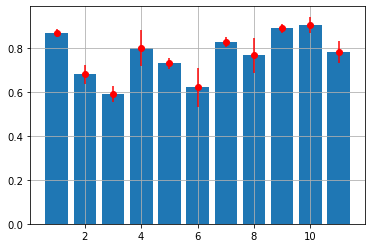

In [50]:
evaluate_results(rf_results)

Mean Train AUC: 0.9198841808981527
Mean Val AUC: 0.7429857448181933


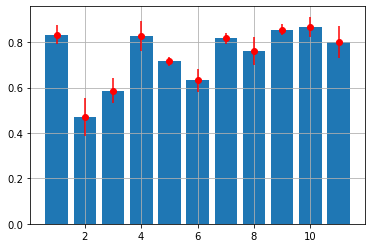

In [51]:
evaluate_results(svc_results)

Mean Train AUC: 0.9254923280741856
Mean Val AUC: 0.7497893676936948


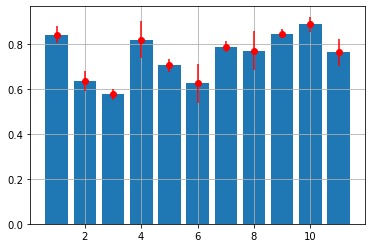

In [52]:
evaluate_results(lr_results)

Mean Train AUC: 0.9843710875173013
Mean Val AUC: 0.7612497272241558


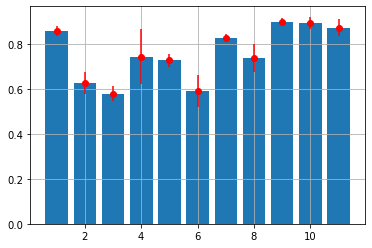

In [53]:
evaluate_results(lgbm_results)

In [54]:
# confusion matrices
task = 6
lgbm_results['val_confusion_matrices'][task-1]

[array([[210,   0],
        [ 11,   0]]),
 array([[189,   0],
        [ 13,   0]]),
 array([[192,   0],
        [ 14,   0]]),
 array([[183,   3],
        [ 12,   0]]),
 array([[169,   4],
        [ 10,   0]])]

## MLP

In [55]:
class MLPDataset(Dataset):
    def __init__(self, X, Y, sample_weights=None):
        super().__init__()
        self.X = X
        self.Y = Y
        self.sample_weights = sample_weights if sample_weights is not None else np.ones(X.shape[0])

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx, :], dtype=torch.float)
        y = torch.tensor(self.Y[idx, :], dtype=torch.float)
        w = torch.tensor(self.sample_weights[idx], dtype=torch.float)
        return x, y, w

In [56]:
class MLP(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(64, out_features)
        )

    def forward(self, x):
        x = self.mlp(x)
        return x

    def predict_proba(self, x):
        self.eval()
        with torch.no_grad():
            logits = self.forward(x)
            return torch.sigmoid(logits).numpy()

In [57]:
# from dlnn2
@torch.enable_grad()
def update_mlp(model, dataloader, metric, optimizer):
    errors = []
    model.train()
    for x, y, w in dataloader:
        logits = model(x)
        mask = y!=-999
        weighted_masked_losses = w.reshape(-1, 1) * mask * metric(logits, y)
        loss = weighted_masked_losses.mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        errors.append(loss.item())
    return errors

@torch.no_grad()
def evaluate_mlp(model, dataloader, metric):
    errors = []
    model.eval()
    with torch.no_grad():
        for x, y, w in dataloader:
            logits = model(x)
            mask = y!=-999
            weighted_masked_losses = w.reshape(-1, 1) * mask * metric(logits, y)
            loss = weighted_masked_losses.mean()
            errors.append(loss.item())
    return errors

In [58]:
class SampleWeighter:
    def __init__(self, coef):
        self.coef = coef

    def fit(self, Y):
       self.task_weights = self._get_task_weights(Y)
       self.activity_weights = self._get_activity_weights(Y)
       self.inactivity_weights = 1 - self.activity_weights

    def get_weights(self, Y):
        activity_weights = np.max(self.activity_weights * (Y==1), axis=1)
        inactivity_weights = np.max(self.inactivity_weights * (Y==0), axis=1)
        task_weights = np.max(self.task_weights * (Y!=-999), axis=1)
        return task_weights * (activity_weights + inactivity_weights)

    def _get_task_weights(self, Y):
        mask = Y!=-999
        task_lengths = np.sum(mask, axis=0)
        total_length = np.sum(task_lengths)
        task_shares = task_lengths / total_length
        task_weights = 1 / task_shares
        return task_weights.reshape(1, -1)

    def _get_activity_weights(self, Y):
        n1 = np.sum(Y==1, axis=0)
        n = np.sum(Y!=-999, axis=0)
        activity_weights = self.get_active_weight(n, n1, self.coef)
        return activity_weights.reshape(1, -1)

    def get_active_weight(self, n, n1, coef):
        w1 = sigmoid(coef*(n1/n) - coef/2)
        return w1

In [59]:
# preprocessing (hyperparameters)
mlp_preprocessing = {
    'nBits': 1024,
    'radius': 2,
    'manual_features': True,
    'dtm': {
        'ngram_range': (1, 2),
        'max_features': 100
    },
    'tfidf': None,
    'pca_embedding': None,
    'lstm_embedding': LSTMEmbedding(lstm_embedding, alphabet, reduction='max'),
    'rdkit_descriptors': True,
    'scaler': MinMaxScaler()
}

# mlp hyperparameters
epochs = 5
batch_size = 16
learning_rate = 0.001
weight_decay = 0

# sample weighter
sample_weighter = SampleWeighter(coef=0)

100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


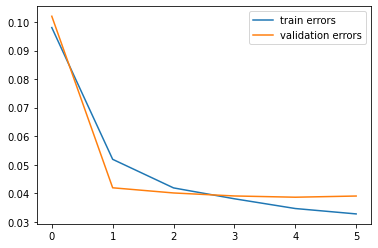

0.03276378367992642
0.03902905248726408


In [60]:
# data preparation
val_fold = 0
X_train, X_val, Y_train, Y_val = get_fold_data(X, Y, val_fold)
X_train_features, X_val_features = preprocess(X_train, X_val, **mlp_preprocessing)
train_dataset = MLPDataset(X_train_features, Y_train)
val_dataset = MLPDataset(X_val_features, Y_val)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=False)

# model etc.
model = MLP(in_features=X_train_features.shape[1], out_features=N_TASKS)
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
metric = nn.BCEWithLogitsLoss(reduction='none')

# training loop
train_errors = [np.mean(evaluate_mlp(model, train_dataloader, metric))]
val_errors = [np.mean(evaluate_mlp(model, val_dataloader, metric))]
for _ in trange(epochs):
    train_errors.append(np.mean(update_mlp(model, train_dataloader, metric, optimizer)))
    val_errors.append(np.mean(evaluate_mlp(model, val_dataloader, metric)))

# learning curves
plt.plot(range(epochs+1), train_errors, label='train errors')
plt.plot(range(epochs+1), val_errors, label='validation errors')
plt.legend()
plt.show()

# final epoch errors
print(train_errors[-1])
print(val_errors[-1])


In [61]:
"""# cross-validation
mlp_results = {
    'val_probas': np.empty((len(data), N_TASKS)),
    'train_auc_scores': [[] for task in range(N_TASKS)],
    'val_auc_scores': [[] for task in range(N_TASKS)],
    'train_confusion_matrices': [[] for task in range(N_TASKS)],
    'val_confusion_matrices': [[] for task in range(N_TASKS)],
}

for val_fold in range(k):
    # handle fold data
    X_train, X_val, Y_train, Y_val = get_fold_data(X, Y, val_fold)
    X_train_features, X_val_features = preprocess(X_train, X_val, **mlp_preprocessing)
    train_dataset = MLPDataset(X_train_features, Y_train)
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)

    # fit mlp
    model = MLP(in_features=X_train_features.shape[1], out_features=N_TASKS)
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    metric = nn.BCEWithLogitsLoss(reduction='none')
    for _ in range(epochs):
        _ = update_mlp(model, train_dataloader, metric, optimizer)

    # evaluate tasks
    for task in range(N_TASKS):
        # data preparation
        X_train_masked, Y_train_masked = mask_data(X_train_features, Y_train, task)
        X_val_masked, Y_val_masked = mask_data(X_val_features, Y_val, task)
        # evaluation
        train_proba = model.predict_proba(torch.tensor(X_train_masked, dtype=torch.float))[:, task]
        val_proba = model.predict_proba(torch.tensor(X_val_masked, dtype=torch.float))[:, task]
        train_auc, train_confusion = get_metrics(Y_train_masked, train_proba)
        val_auc, val_confusion = get_metrics(Y_val_masked, val_proba)
        # store metrics
        mlp_results['train_auc_scores'][task].append(train_auc)
        mlp_results['val_auc_scores'][task].append(val_auc)
        mlp_results['train_confusion_matrices'][task].append(train_confusion)
        mlp_results['val_confusion_matrices'][task].append(val_confusion)
        # monitoring
        print(f'Fold {val_fold} - Task {task}')
        print(f'\tTrain Samples: {len(X_train_masked)} ... Val Samples: {len(X_val_masked)} ...')
        print(f'\tTrain AUC {train_auc} ... Val AUC: {val_auc}')"""

"# cross-validation\nmlp_results = {\n    'val_probas': np.empty((len(data), N_TASKS)),\n    'train_auc_scores': [[] for task in range(N_TASKS)],\n    'val_auc_scores': [[] for task in range(N_TASKS)],\n    'train_confusion_matrices': [[] for task in range(N_TASKS)],\n    'val_confusion_matrices': [[] for task in range(N_TASKS)],\n}\n\nfor val_fold in range(k):\n    # handle fold data\n    X_train, X_val, Y_train, Y_val = get_fold_data(X, Y, val_fold)\n    X_train_features, X_val_features = preprocess(X_train, X_val, **mlp_preprocessing)\n    train_dataset = MLPDataset(X_train_features, Y_train)\n    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)\n\n    # fit mlp\n    model = MLP(in_features=X_train_features.shape[1], out_features=N_TASKS)\n    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)\n    metric = nn.BCEWithLogitsLoss(reduction='none')\n    for _ in range(epochs):\n        _ = update_mlp(model, train_dataloader, metric, 

In [62]:
#evaluate_results(mlp_results)

## Final Fit

In [63]:
X_train = X.copy()
Y_train = Y.copy()
X_test = pd.read_csv('data/smiles_test.csv', index_col=0).reset_index(drop=True)['smiles']

In [64]:
def predict_test(model, preprocessing_hyperparameters, coef):
    predictions = np.zeros((len(X_test), N_TASKS))
    X_train_features, X_test_features = preprocess(X_train, X_test, **preprocessing_hyperparameters)
    for task in range(N_TASKS):
        X_train_masked, Y_train_masked = mask_data(X_train_features, Y_train, task)
        sample_weights = get_sample_weights(Y_train_masked, coef)
        model.fit(X_train_masked, Y_train_masked, sample_weights)
        test_proba = model.predict_proba(X_test_features)[:, 1]
        predictions[:, task] = test_proba
    return predictions

### Random Forest

In [65]:
rf = RandomForestClassifier(**rf_hyperparameters)
rf_predictions = predict_test(rf, rf_preprocessing, rf_coef)

### SVC

In [66]:
svc = SVC(**svc_hyperparameters)
svc_predictions = predict_test(svc, svc_preprocessing, svc_coef)

### Logistic Regression

In [67]:
lr = LogisticRegression(**lr_hyperparameters)
lr_predictions = predict_test(lr, lr_preprocessing, lr_coef)

### LightGBM

In [68]:
lgbm = lgb.LGBMClassifier(**lgbm_hyperparameters)
lgbm_predictions = predict_test(lgbm, lgbm_preprocessing, lgbm_coef)

## Ensembling

In [69]:
reduction = 'mean'

In [70]:
def ensemble_predictions(predictions, scores, reduction='mean'):
    if reduction=='mean':
        ensembled_predictions = np.mean(predictions, axis=0)
    if reduction=='weighted':
        weights = (np.argsort(-np.array(scores), axis=0) + 1) / 10
        weights = weights.transpose((1, 0))
        ensembled_predictions = np.sum(np.array(predictions).transpose((1, 2, 0)) * weights, axis=2)
    return ensembled_predictions

In [71]:
rf_scores = [np.mean(x) for x in rf_results['val_auc_scores']]
svc_scores = [np.mean(x) for x in svc_results['val_auc_scores']]
lr_scores = [np.mean(x) for x in lr_results['val_auc_scores']]
lgbm_scores = [np.mean(x) for x in lgbm_results['val_auc_scores']]

In [72]:
predictions = [rf_predictions, svc_predictions, lr_predictions, lgbm_predictions]
scores = [rf_scores, svc_scores, lr_scores, lgbm_scores]

ensembled_predictions = ensemble_predictions(predictions, scores, reduction)
result = pd.DataFrame(ensembled_predictions, columns=['task' + str(i) for i in range(1, 12)])
result.to_csv(SUBMISSION_FILE)

## Overfit Public Leaderboard (DO NOT EXECUTE)

### Task 2

In [73]:
sub4 = pd.read_csv('data/submission4(4444weighted).csv', index_col=0).reset_index(drop=True)
sub6 = pd.read_csv('data/submission6(regularized5).csv', index_col=0).reset_index(drop=True)

In [74]:
sub6['task2'] = sub4['task2']
sub6.to_csv(SUBMISSION_FILE)

### Task 8

In [75]:
sub2 = pd.read_csv('data/submission2(0011weighted).csv', index_col=0).reset_index(drop=True) 
sub8 = pd.read_csv('data/submission8(overfit).csv', index_col=0).reset_index(drop=True)

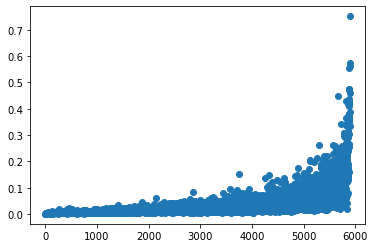

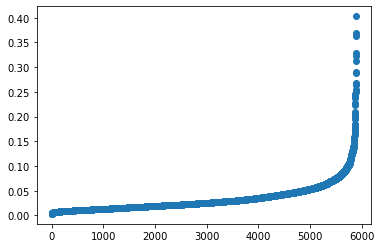

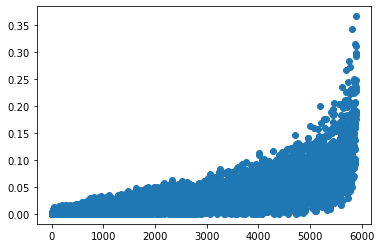

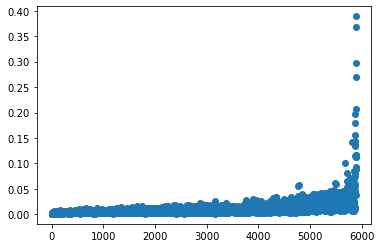

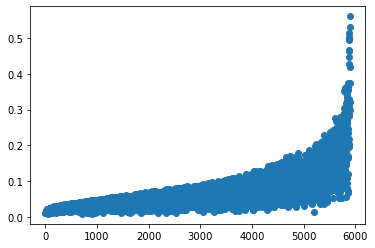

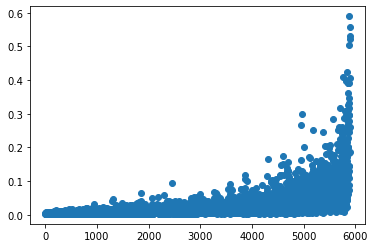

In [76]:
order = np.argsort(sub8['task8'].values)

plt.scatter(range(5896), sub2['task8'].values[order], label='worst')
plt.show()
plt.scatter(range(5896), sub8['task8'].values[order], label='best')
plt.show()
plt.scatter(range(5896), rf_predictions[:, 7][order], label='rf')
plt.show()
plt.scatter(range(5896), svc_predictions[:, 7][order], label='svc')
plt.show()
plt.scatter(range(5896), lr_predictions[:, 7][order], label='lr')
plt.show()
plt.scatter(range(5896), lgbm_predictions[:, 7][order], label='lgbm')
plt.show()

In [77]:
np.corrcoef(sub2['task8'].values, rf_predictions[:, 7])

array([[1.        , 0.47302061],
       [0.47302061, 1.        ]])

In [78]:
np.mean(svc_predictions[:, 7])

0.010290426786900807

In [79]:
np.corrcoef((rf_predictions[:, 7], svc_predictions[:, 7], lr_predictions[:, 7], lgbm_predictions[:, 7]))

array([[1.        , 0.44392076, 0.49809577, 0.63151952],
       [0.44392076, 1.        , 0.68884394, 0.47629007],
       [0.49809577, 0.68884394, 1.        , 0.50873248],
       [0.63151952, 0.47629007, 0.50873248, 1.        ]])

In [80]:
sub8['task8'] = (rf_predictions[:, 7] + lgbm_predictions[:, 7]) / 2
sub8.to_csv(SUBMISSION_FILE)